In [1]:
%matplotlib inline

import logging
import matplotlib.pyplot as plt
import time
import numpy as np

from tqdm import tqdm
from collections import Counter
from functools import partial
from gendas.engine import Gendas

logging.basicConfig(format='[%(name)s] %(asctime)s %(levelname)s: %(message)s', datefmt='%H:%M:%S', level=logging.INFO)

In [2]:
# Function to plot a histrogram from a dictionary of frequencies
def hist_from_dict(c):
    labels, values = zip(*c.items())
    indexes = np.arange(len(labels))
    width = 1
    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0.5, labels)
    plt.show()

In [3]:
# Create a Gendas engine
gd = Gendas('data/gendas.conf')

In [4]:
# Divide the gene in 'bins' regions and check at what regions is the 'pos' mutation.
def compute_bin(pos, begin, end, strand, bins=15):
    length = end - begin + 1
    relative = pos - begin if strand == '+' else end - pos
    return int((relative/length)*bins)

In [5]:
%%time
# Compute the 'bins' frequencies of all the observed mutations in the dataset "variants"
bins_muts = Counter(tqdm(
    gd['variants'].merge(gd['exons']).merge(gd['genes'], on=['GENE']).map(
        lambda r: compute_bin(
            r['variants']['POS'],
            r['genes']['BEGIN'],
            r['genes']['END'],
            r['genes']['STRAND']
        )
    )
))

202it [00:01, 131.87it/s]

CPU times: user 29.8 ms, sys: 11.8 ms, total: 41.6 ms
Wall time: 1.54 s


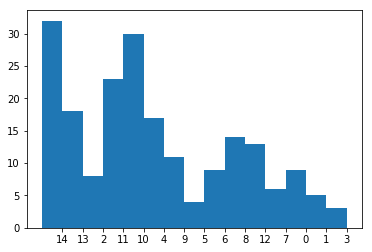

In [6]:
hist_from_dict(bins_muts)

In [7]:
# Compute 'bins' frequency of all the nucleotides in a exon
def compute_exon_bins(r, bins=10):    
    start, stop = r['exons']['START'], r['exons']['STOP']
    fn = partial(compute_bin, begin=r['genes']['BEGIN'], end=r['genes']['END'], strand=r['genes']['STRAND'])
    return Counter(map(fn, range(start, stop+1)))

In [8]:
%%time
bins_nucleotide = Counter()
for c in tqdm(gd['exons'].merge(gd['genes']).map(compute_exon_bins)):
    bins_nucleotide += c

118it [00:00, 2411.68it/s]

CPU times: user 29.8 ms, sys: 196 µs, total: 30 ms
Wall time: 56 ms


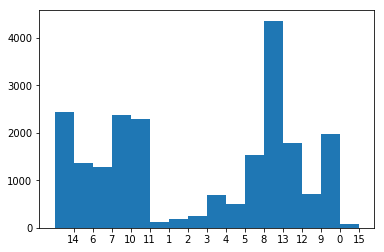

In [9]:
hist_from_dict(bins_nucleotide)

In [10]:
# Normalize the observed bins frequency by the exome mapping frequency.
bins = {k: bins_muts[k] / bins_nucleotide[k] for k in bins_muts}

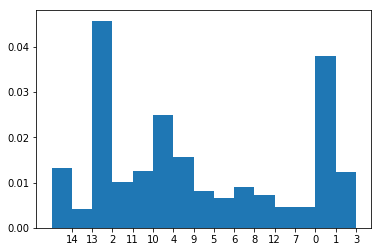

In [11]:
hist_from_dict(bins)